In [ ]:
import re
import time

# Ignore warning
import warnings

import matplotlib.pyplot as plt

# importing the NLP libraries that will be used for preprocessing
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Import classifiers
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm
from wordcloud import WordCloud

pd.set_option("display.max_columns", None)


warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("./labeled_data/labeled_foi_text_2023_05_01.csv")

In [ ]:
df.head()

ROW_ID                                           FOI_TEXT  \
0  1969025  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...   
1  1426265  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
2  2609625  IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...   
3  2813837  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
4  1337517  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   

         PRIMARY_LABEL  
0  Quality Engineering  
1  Quality Engineering  
2  Quality Engineering  
3  Quality Engineering  
4  Quality Engineering

In [ ]:
print("Total Rows:", df.shape[0])  # check the shape of dataset
print("Total Columns:", df.shape[1])

Total Rows: 5692
Total Columns: 3


In [ ]:
print(
    "Features: {}".format(df.columns.tolist())
)  # check the columns names inside the dataset

Features: ['ROW_ID', 'FOI_TEXT', 'PRIMARY_LABEL']


In [ ]:
print(
    "Any Duplicated Values: {}".format(df.duplicated().any())
)  # check duplicated values

Any Duplicated Values: False


In [ ]:
df.info()  # get general information of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5692 entries, 0 to 5691
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ROW_ID         5692 non-null   int64 
 1   FOI_TEXT       5692 non-null   object
 2   PRIMARY_LABEL  5692 non-null   object
dtypes: int64(1), object(2)
memory usage: 133.5+ KB


In [ ]:
df.isnull().sum()  # check missing values

ROW_ID           0
FOI_TEXT         0
PRIMARY_LABEL    0
dtype: int64

In [ ]:
def target_distribution(df_final, col):
    plt.figure(figsize=(17, 7))

    plt.subplot(1, 2, 1)

    ax = (
        df_final[col]
        .value_counts()
        .plot(kind="bar", color=["blue", "green", "red", "purple", "orange"])
    )

    plt.xlabel("Score Category", fontsize=16)
    plt.ylabel("Frequency of Target", fontsize=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Frequency Distribution of Target", fontsize=18)
    for p in ax.patches:
        ax.annotate(
            str(p.get_height()), (p.get_x() * 1.05, p.get_height() * 1.01), size=15
        )

    plt.subplot(1, 2, 2)

    df_final[col].value_counts().plot.pie(
        explode=[0.0, 0.1, 0.1, 0.1, 0.5],
        autopct="%1.2f%%",
        shadow=False,
        colors=["blue", "green", "red", "purple", "orange"],
        textprops={"fontsize": 15, "color": "black"},
        startangle=20,
    )
    plt.ylabel("target", fontsize=16)
    plt.title("Proportional Distribution of Target", fontsize=18)
    plt.show()

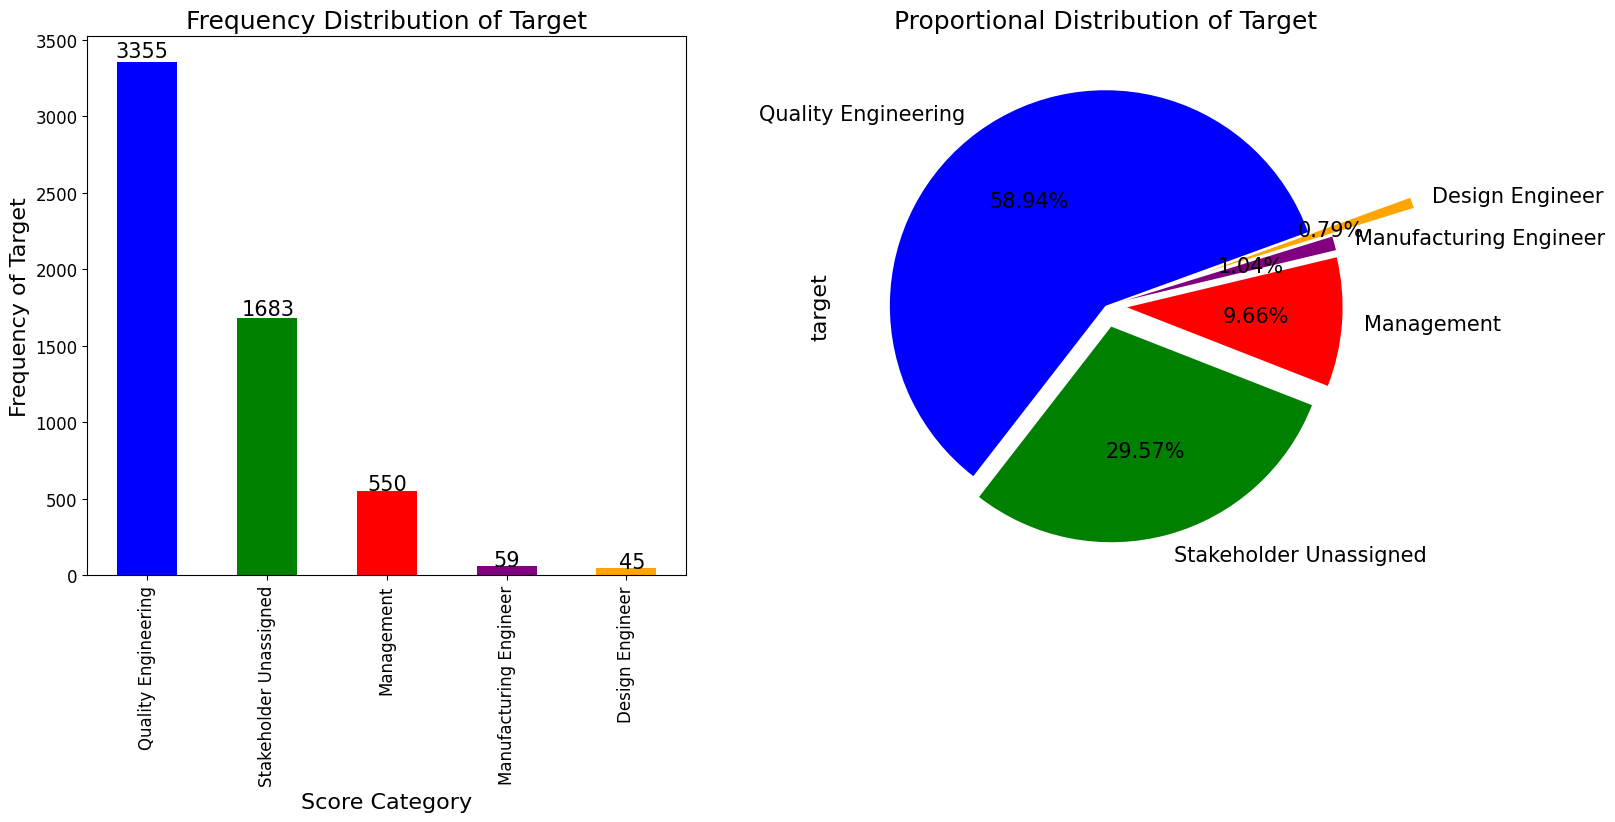

In [ ]:
target_distribution(df, "PRIMARY_LABEL")

- From above, we can see the distribution of results in which our target feature is in imbalanced form.
- Clearly, we can see that our dataset is imbalanced form. Therefore, accuracy evaluation is not good when the dataset is in an imbalanced form, accuracy is biased on the majority class.
- We will check the different performance metrics Precision, Recall, and F1-score on testing data and see how models perform according to these performance metrics.

In [ ]:
df["text_length"] = df["FOI_TEXT"].apply(
    lambda x: len(x.split())
)  # get the length of text
df.head()

ROW_ID                                           FOI_TEXT  \
0  1969025  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...   
1  1426265  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
2  2609625  IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...   
3  2813837  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
4  1337517  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   

         PRIMARY_LABEL  text_length  
0  Quality Engineering           32  
1  Quality Engineering           37  
2  Quality Engineering           31  
3  Quality Engineering           45  
4  Quality Engineering           52

In [ ]:
print("Average Distribution of Number of Words: \t", int(df["text_length"].mean()))

Average Distribution of Number of Words: 	 43


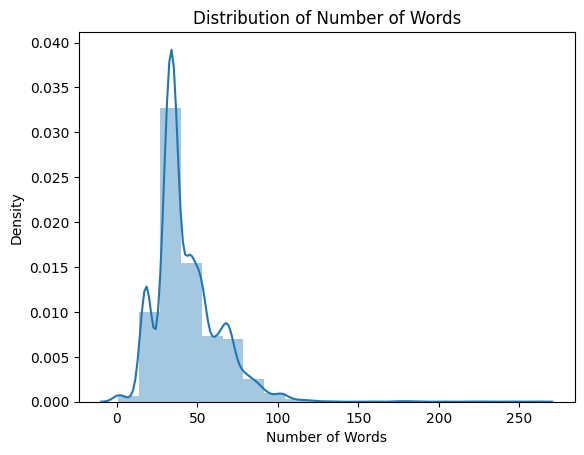

In [ ]:
ax = sns.distplot(df["text_length"], norm_hist=True, bins=20)
plt.title("Distribution of Number of Words")
plt.xlabel("Number of Words")
plt.show()

In [ ]:
print("Average Text: ", int(np.mean(df["text_length"])), " Number of words")
print("Longest Text: ", max(df["text_length"]), " Number of words")
print("Shortest Text: ", min(df["text_length"]), " Number of word.")

Average Text:  43  Number of words
Longest Text:  260  Number of words
Shortest Text:  1  Number of word.


In [ ]:
df[df["text_length"] == 1]

ROW_ID     FOI_TEXT           PRIMARY_LABEL  text_length
618   3265893       (B)(4)  Stakeholder Unassigned            1
1342  2183359       (B)(4)  Stakeholder Unassigned            1
1653  1937352  COM-(B)(4).     Quality Engineering            1
2827  1940488  COM-(B)(4).  Stakeholder Unassigned            1
2931  2040371  COM-(B)(4).  Stakeholder Unassigned            1
3010  3240092  COM-(B)(4).  Stakeholder Unassigned            1
3020  2937457  COM-(B)(4).  Stakeholder Unassigned            1
3042  3456855  COM-(B)(4).  Stakeholder Unassigned            1
3078  2936782  COM-(B)(4).  Stakeholder Unassigned            1
3171  3430034       (B(4).  Stakeholder Unassigned            1
3196  3264467  COM-(B)(4).  Stakeholder Unassigned            1
3729  3834179  COM-(B)(4).  Stakeholder Unassigned            1
3736  3433447  COM-(B)(4).  Stakeholder Unassigned            1
3829  1942005  COM-(B)(4).  Stakeholder Unassigned            1
4023  3433672  COM-(B)(4).  Stakeholder Unassigned            1
4183  3078803  COM-(B)(4).  Stakeholder Unassigned            1
4206  3265280  COM-(B)(4).  Stakeholder Unassigned            1
4313  4037666       (B)(4)  Stakeholder Unassigned            1
4458  1935932  COM-(B)(4).  Stakeholder Unassigned            1
4502  3179615  COM-(B)(4).  Stakeholder Unassigned            1
4523  3239966  COM-(B)(4).  Stakeholder Unassigned            1
4599  3446251  COM-(B)(4).  Stakeholder Unassigned            1
4628  2998460  COM-(B)(4).  Stakeholder Unassigned            1
4690  3165472  COM-(B)(4).  Stakeholder Unassigned            1
4732  3458032  COM-(B)(4).  Stakeholder Unassigned            1
4764  3841055  COM-(B)(4).  Stakeholder Unassigned            1
4945  3290954  COM-(B)(4).  Stakeholder Unassigned            1
5433  2937178  COM-(B)(4).  Stakeholder Unassigned            1
5531  3804231  COM-(B)(4).  Stakeholder Unassigned            1

In [ ]:
# !pip install WordCloud

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Average POSITIVE Review Stopword Ratio:	 0.39


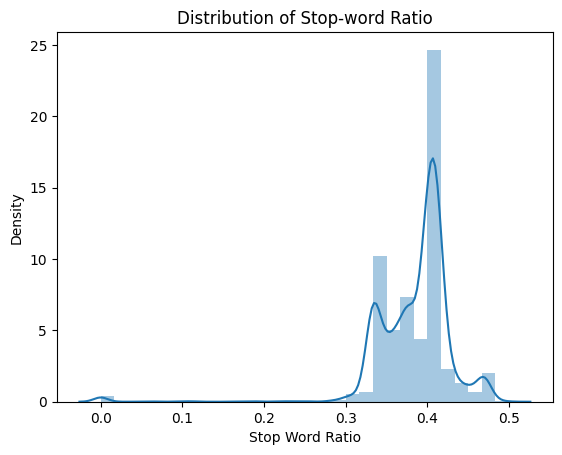

In [ ]:
stop_words = set(stopwords.words("english"))


# function to calculate the stop words raion
def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word.lower() in stop_words:
            num_stop_words += 1
        num_total_words += 1
    return num_stop_words / num_total_words


stopwords = df.FOI_TEXT.apply(stop_words_ratio)


# plotting the distribution
sns.distplot(stopwords, norm_hist=True, bins=30)
print("Average POSITIVE Review Stopword Ratio:\t", round(stopwords.values.mean(), 2))
plt.title("Distribution of Stop-word Ratio")
plt.xlabel("Stop Word Ratio")
plt.show()

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")


ps = PorterStemmer()  # creating an instance of the class

stopwords.words("english")[:10]  # <-- import the english stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
def preprocess_text(text):
    """In preprocess_text function we will apply all the things that are given below:
    - removing special characters
    - removing punctuations
    - removing numbers
    - removing stopwords
    - doing stemming
    - transforming in lowercase
    - removing excessive whitespaces
    """
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", str(text))
    # remove punctuations in string
    text = re.sub(r"[^\w\s]", "", str(text))
    # 1. tokenize
    tokens = nltk.word_tokenize(text)
    # 2. check if stopword and stemming the word
    tokens = [ps.stem(w) for w in tokens if w.lower() not in stopwords.words("english")]
    # 3. join back together
    text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [ ]:
df["clean_text"] = df["FOI_TEXT"].apply(lambda x: preprocess_text(x))
df.head()

ROW_ID                                           FOI_TEXT  \
0  1969025  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...   
1  1426265  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
2  2609625  IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...   
3  2813837  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
4  1337517  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   

         PRIMARY_LABEL  text_length  \
0  Quality Engineering           32   
1  Quality Engineering           37   
2  Quality Engineering           31   
3  Quality Engineering           45   
4  Quality Engineering           52   

                                          clean_text  
0  report transmitt lost connect pump greater hou...  
1  report signal loss one hour occur product data...  
2  report transmitt fail error occur data evalu a...  
3  report signal loss one hour occur review share...  
4  report signal loss one hour occur product eval...

In [ ]:
# define a function for getting all words from the text


def returning_tokinize_list(df, column_name):
    df = df.reset_index(drop=True)
    tokenize_list = [word_tokenize(df[column_name][i]) for i in range(df.shape[0])]
    final = [j for i in tokenize_list for j in i]
    return final

In [ ]:
# get the all words of text into list
tokenize_list_words = returning_tokinize_list(df, "clean_text")

In [ ]:
# function for words in dataframe format


def table_format(data_list, column_name):
    df_ = pd.DataFrame(data_list, columns=[column_name, "Frequency_distribution"])
    return df_


# function for extracting the most common words in reviews text
def most_common_words(cleaned_col_name_list, common_words=10):
    fdist = FreqDist(cleaned_col_name_list)
    most_common = fdist.most_common(common_words)
    return most_common

In [ ]:
# draw a graph of word which are most common


def word_cloud(data):
    unique_string = (" ").join(data)
    wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(
        unique_string
    )
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("wordCloud" + ".png", bbox_inches="tight")
    plt.show()
    plt.close()

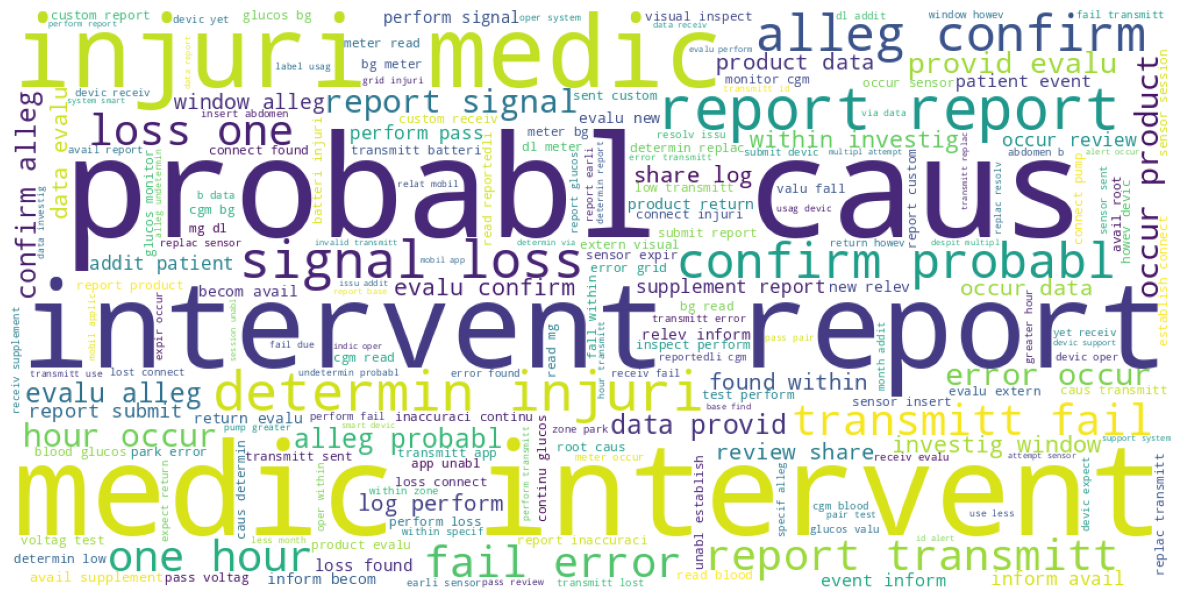

In [ ]:
# draw word cloud
word_cloud(tokenize_list_words)

In [ ]:
# lets try to check the 15 most common words
MCW = most_common_words(tokenize_list_words, common_words=15)
table_format(MCW, "word")

word  Frequency_distribution
0      report                   10166
1        caus                    4531
2    determin                    4241
3       alleg                    4002
4     probabl                    3963
5       occur                    3962
6       medic                    3931
7   intervent                    3922
8      injuri                    3917
9       evalu                    3906
10  transmitt                    3882
11    confirm                    3748
12      could                    3592
13       loss                    3016
14       data                    2990

In [ ]:
label_enc = LabelEncoder()
df["PRIMARY_LABEL_ENC"] = label_enc.fit_transform(df["PRIMARY_LABEL"])

In [ ]:
label_enc.classes_

array(['Design Engineer', 'Management', 'Manufacturing Engineer',
       'Quality Engineering', 'Stakeholder Unassigned'], dtype=object)

In [ ]:
X = df["clean_text"]  # independent feature
y = df["PRIMARY_LABEL_ENC"]  # dependent feature

In [ ]:
def splitting_dataset(X, y, test_size=0.25):
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, stratify=y
    )

    # lets try to check the shape of training and testing
    print("training shape :", X_train.shape)
    print("testing shape :", X_test.shape)
    return X_train, X_test, y_train, y_test

In [ ]:
def get_features_from_text(X):
    # Fit and transform the data to a document-term matrix using TfidfVectorizer
    tfidf = TfidfVectorizer(min_df=2)
    X_tfidf = tfidf.fit_transform(X.values)
    print("Number of features TF-IDF: %d" % len(tfidf.get_feature_names_out()))
    return X_tfidf.toarray()

In [ ]:
X_tfidff = get_features_from_text(X)

Number of features TF-IDF: 470


# Imbalanced-Dataset

**The problem of imbalanced dataset, the trained model are often biased towards majority class ,but examples from the minority class tend to be misclassified** <br>
**There are two options to deal with imbalanced datasets.Oversampling (incresaing the samples of minority class) or undersampling (decreasing the samples of majority class) depending on number of instances of each class**

## **Random oversampling - SMOTE**

In [ ]:
oversample = SMOTE(random_state=42)
overX, overY = oversample.fit_resample(X_tfidff, y)

pd.DataFrame(overY)["PRIMARY_LABEL_ENC"].value_counts()

3    3355
4    3355
0    3355
1    3355
2    3355
Name: PRIMARY_LABEL_ENC, dtype: int64

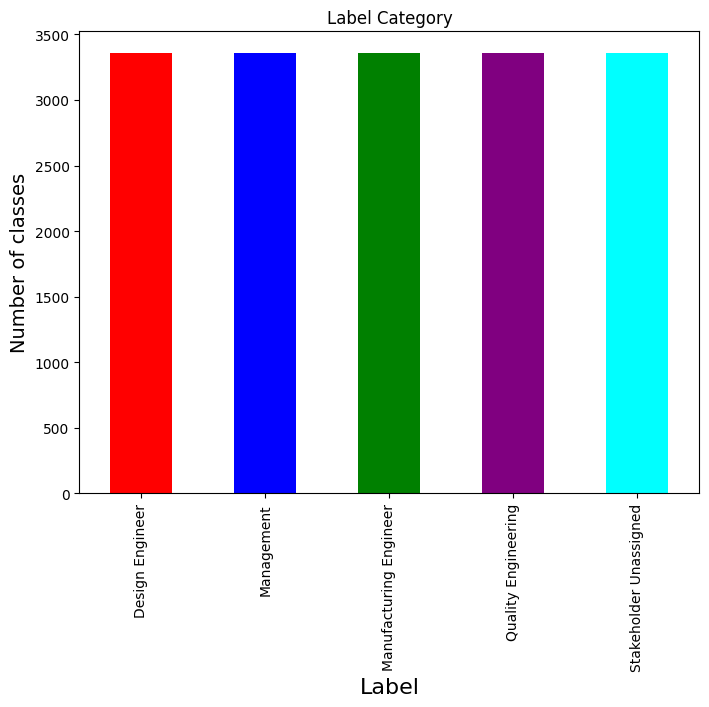

In [ ]:
# First over sampling to make all classes equal

ax = (
    pd.DataFrame(overY)["PRIMARY_LABEL_ENC"]
    .value_counts()
    .plot(
        kind="bar",
        color=["red", "blue", "green", "purple", "cyan"],
        title="Label Category",
        figsize=(8, 6),
    )
)

plt.xticks(range(5), label_enc.classes_.tolist())
ax.set_xlabel("Label", fontsize=16)
ax.set_ylabel("Number of classes", fontsize=14)
plt.show()

In [ ]:
# split data into 75% training and 25% testing set
X_train_tfidf, X_test_tfidf, y_train, y_test = splitting_dataset(
    overX, overY, test_size=0.25
)

training shape : (12581, 470)
testing shape : (4194, 470)


In [ ]:
def results(model, y_pred, y_test):
    accuracy = round(accuracy_score(y_pred, y_test) * 100, 4)
    precision = round(precision_score(y_pred, y_test, average="macro") * 100, 4)
    recall = round(recall_score(y_pred, y_test, average="macro") * 100, 4)
    f1_scr = round(f1_score(y_pred, y_test, average="macro") * 100, 4)

    print("\nAccuracy: {}%".format(accuracy))
    print("Precision: {}%".format(precision))
    print("Recall: {}%".format(recall))
    print("F1-Score: {}%".format(f1_scr))
    print()
    print("Classification Report:")
    print(classification_report(y_pred, y_test, target_names=label_enc.classes_))
    print()
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_pred,
        y_test,
        ax=ax,
        display_labels=label_enc.classes_,
        xticks_rotation="vertical",
    )
    plt.show()

    return {
        "Model": model.__class__.__name__,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1_scr,
    }

In [ ]:
def train_model(model):
    # Record the start time
    start_time = time.time()

    # Fit the model on the training data
    model.fit(X_train_tfidf, y_train)

    # Record the end time
    end_time = time.time()

    # Compute the training time in seconds
    training_time = end_time - start_time
    print(f"Training time: {training_time:.3f} seconds")

    # predict the model on testing data
    y_pred = model.predict(X_test_tfidf)

    # get results
    RESULTS_LR = results(model, y_pred, y_test)

    # Add the training time to RESULTS_LR
    RESULTS_LR["Training time (s)"] = training_time

    return RESULTS_LR

In [ ]:
def get_model_results(res):
    # Convert the dictionary to a DataFrame
    return pd.DataFrame.from_dict([res]).set_index("Model")

In [ ]:
def check_cross_validation_score(fold_list, model):
    RES = []
    for cv in fold_list:
        class_counts = y_test.value_counts()

        # Check if the smallest class has enough samples for the current number of splits
        if class_counts.min() < cv:
            print(
                f"Skipping cross-validation for Fold-{cv} due to insufficient samples in the smallest class."
            )
            continue

        cv_results = cross_validate(
            model,
            X_test_tfidf,
            y_test,
            cv=cv,
            return_train_score=True,
            scoring="f1_macro",
        )
        # Print the average test score and average training score across all folds
        print(
            f"Fold-{cv}\t\tAverage F1 train score: {cv_results['train_score'].mean():.3f} - Average F1 test score: {cv_results['test_score'].mean():.3f}"
        )
        RES.append(
            (
                f"{model.__class__.__name__}-Fold-{cv}",
                cv_results["train_score"].mean(),
                cv_results["test_score"].mean(),
            )
        )
    return RES

In [ ]:
def get_cv_results(res):
    return pd.DataFrame(
        res, columns=["cross-validation", "F1_train_score", "F1_test_score"]
    )

In [ ]:
model_tuple = [
    (
        "LogisticRegression",
        LogisticRegression(
            **{
                "C": 10,
                "multi_class": "ovr",
                "penalty": "l2",
                "random_state": 42,
                "solver": "liblinear",
            }
        ),
    ),
    ("GaussianNB", GaussianNB(**{"var_smoothing": 1e-05})),
    (
        "RandomForest",
        RandomForestClassifier(
            **{
                "bootstrap": False,
                "max_depth": 10,
                "min_samples_split": 5,
                "n_estimators": 100,
                "random_state": 42,
            }
        ),
    ),
    (
        "SVM",
        SVC(
            **{
                "C": 10,
                "decision_function_shape": "ovr",
                "kernel": "rbf",
                "random_state": 42,
            }
        ),
    ),
    (
        "AdaBoost",
        AdaBoostClassifier(
            **{
                "base_estimator": DecisionTreeClassifier(max_depth=5),
                "learning_rate": 0.01,
                "n_estimators": 100,
                "random_state": 42,
            }
        ),
    ),
    (
        "XGBoost",
        xgb.XGBClassifier(
            **{
                "learning_rate": 0.1,
                "max_depth": 5,
                "n_estimators": 100,
                "num_class": 5,
                "objective": "multi:softmax",
                "random_state": 42,
            }
        ),
    ),
    (
        "StochasticGradientDescent",
        SGDClassifier(
            **{
                "alpha": 0.0001,
                "loss": "modified_huber",
                "penalty": "elasticnet",
                "random_state": 42,
            }
        ),
    ),
]

model running:   0%|          | 0/7 [00:00<?, ?it/s]

			 LogisticRegression
Training time: 0.758 seconds

Accuracy: 81.4735%
Precision: 81.4779%
Recall: 83.5969%
F1-Score: 80.7383%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.96      0.98       873
            Management       0.72      0.69      0.71       875
Manufacturing Engineer       1.00      0.69      0.81      1221
   Quality Engineering       0.49      0.90      0.64       463
Stakeholder Unassigned       0.86      0.94      0.90       762

              accuracy                           0.81      4194
             macro avg       0.81      0.84      0.81      4194
          weighted avg       0.86      0.81      0.82      4194


Confusion Matrix:


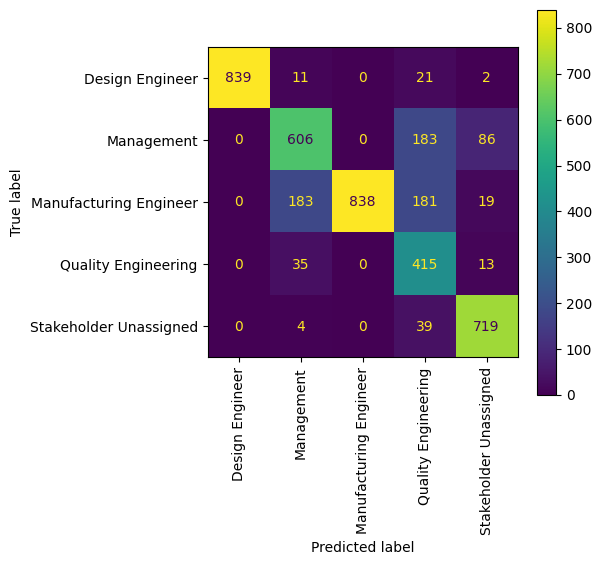

                    Accuracy  Precision   Recall       F1  Training time (s)
Model                                                                       
LogisticRegression   81.4735    81.4779  83.5969  80.7383           0.758217

Fold-5		Average F1 train score: 0.811 - Average F1 test score: 0.796
Fold-10		Average F1 train score: 0.815 - Average F1 test score: 0.804
Fold-15		Average F1 train score: 0.815 - Average F1 test score: 0.804
Fold-20		Average F1 train score: 0.814 - Average F1 test score: 0.802
____________________________________________________________________________________________________
			 GaussianNB
Training time: 0.091 seconds

Accuracy: 63.114%
Precision: 63.122%
Recall: 64.9656%
F1-Score: 58.9244%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.55      0.71      1513
            Management       0.41      0.75      0.53       463
Manufacturing Engineer       0.97      0.59      0.73

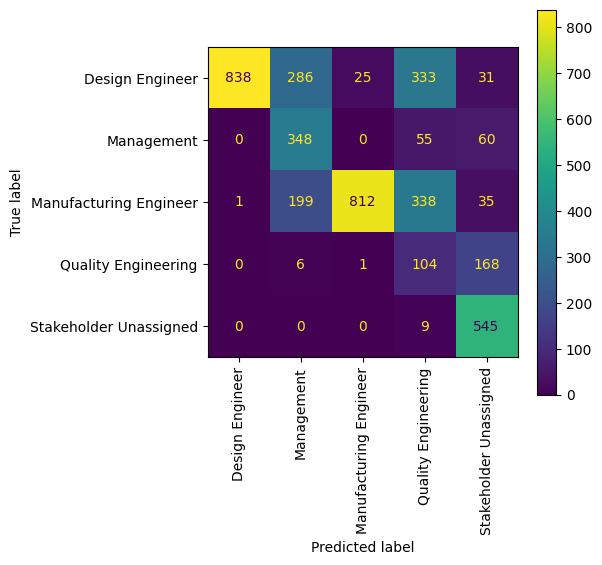

            Accuracy  Precision   Recall       F1  Training time (s)
Model                                                               
GaussianNB    63.114     63.122  64.9656  58.9244           0.090566

Fold-5		Average F1 train score: 0.612 - Average F1 test score: 0.605
Fold-10		Average F1 train score: 0.611 - Average F1 test score: 0.604
Fold-15		Average F1 train score: 0.611 - Average F1 test score: 0.601
Fold-20		Average F1 train score: 0.611 - Average F1 test score: 0.600
____________________________________________________________________________________________________
			 RandomForest
Training time: 2.344 seconds

Accuracy: 81.7835%
Precision: 81.7874%
Recall: 84.1478%
F1-Score: 81.3565%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.97      0.99       860
            Management       0.75      0.66      0.70       957
Manufacturing Engineer       0.98      0.71      0.82      1167
   Qualit

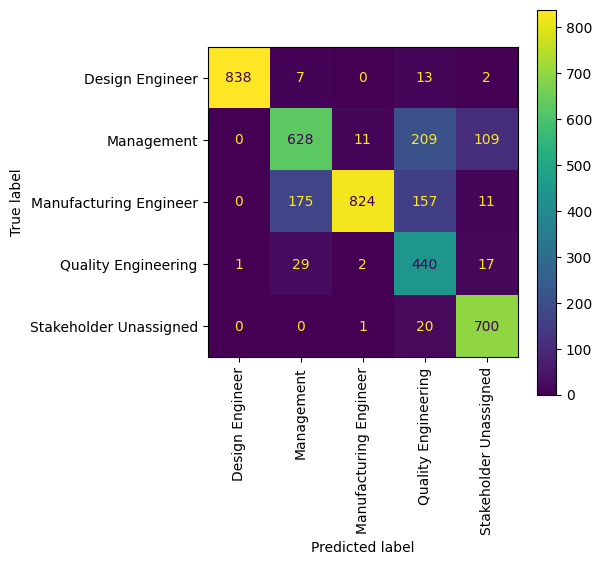

                        Accuracy  Precision   Recall       F1  \
Model                                                           
RandomForestClassifier   81.7835    81.7874  84.1478  81.3565   

                        Training time (s)  
Model                                      
RandomForestClassifier           2.343538  

Fold-5		Average F1 train score: 0.838 - Average F1 test score: 0.807
Fold-10		Average F1 train score: 0.837 - Average F1 test score: 0.808
Fold-15		Average F1 train score: 0.836 - Average F1 test score: 0.808
Fold-20		Average F1 train score: 0.835 - Average F1 test score: 0.809
____________________________________________________________________________________________________
			 SVM
Training time: 7.550 seconds

Accuracy: 83.0234%
Precision: 83.0259%
Recall: 84.1032%
F1-Score: 82.8634%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.98      0.99       855
            Management   

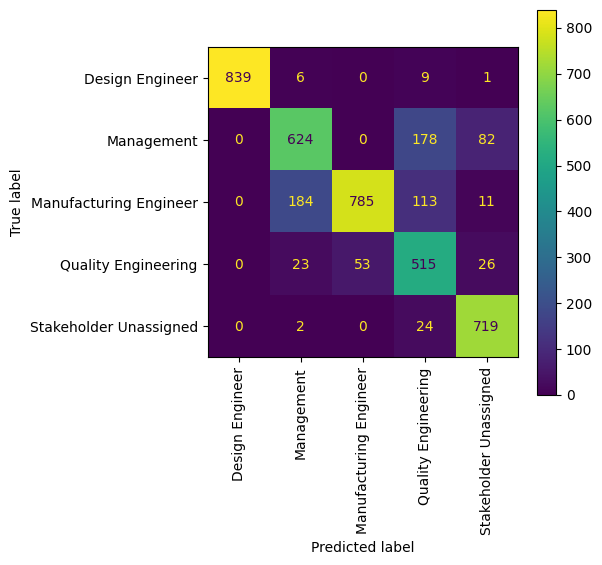

       Accuracy  Precision   Recall       F1  Training time (s)
Model                                                          
SVC     83.0234    83.0259  84.1032  82.8634           7.549622

Fold-5		Average F1 train score: 0.832 - Average F1 test score: 0.810
Fold-10		Average F1 train score: 0.833 - Average F1 test score: 0.815
Fold-15		Average F1 train score: 0.833 - Average F1 test score: 0.814
Fold-20		Average F1 train score: 0.833 - Average F1 test score: 0.814
____________________________________________________________________________________________________
			 AdaBoost
Training time: 22.130 seconds

Accuracy: 79.2799%
Precision: 79.2823%
Recall: 79.0978%
F1-Score: 78.6981%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.98      0.99       851
            Management       0.60      0.64      0.62       782
Manufacturing Engineer       0.89      0.74      0.81      1018
   Quality Engineering     

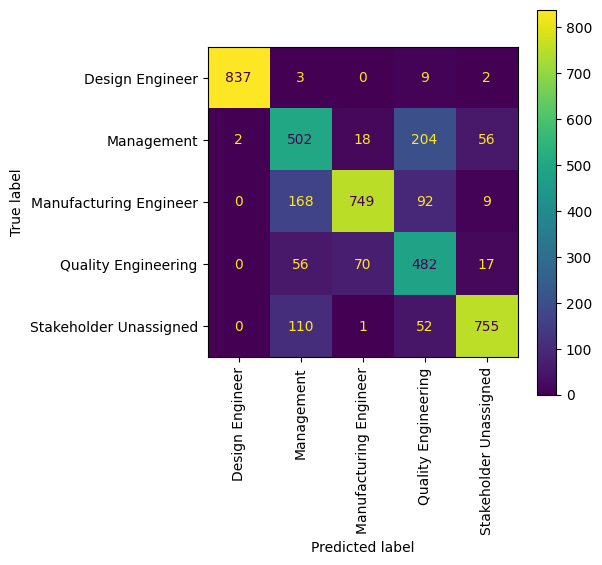

                    Accuracy  Precision   Recall       F1  Training time (s)
Model                                                                       
AdaBoostClassifier   79.2799    79.2823  79.0978  78.6981          22.129671

Fold-5		Average F1 train score: 0.806 - Average F1 test score: 0.772
Fold-10		Average F1 train score: 0.811 - Average F1 test score: 0.774
Fold-15		Average F1 train score: 0.815 - Average F1 test score: 0.782
Fold-20		Average F1 train score: 0.808 - Average F1 test score: 0.779
____________________________________________________________________________________________________
			 XGBoost
Training time: 8.291 seconds

Accuracy: 82.9518%
Precision: 82.9541%
Recall: 83.9812%
F1-Score: 82.8723%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.98      0.99       849
            Management       0.75      0.68      0.72       923
Manufacturing Engineer       0.93      0.74      0.82 

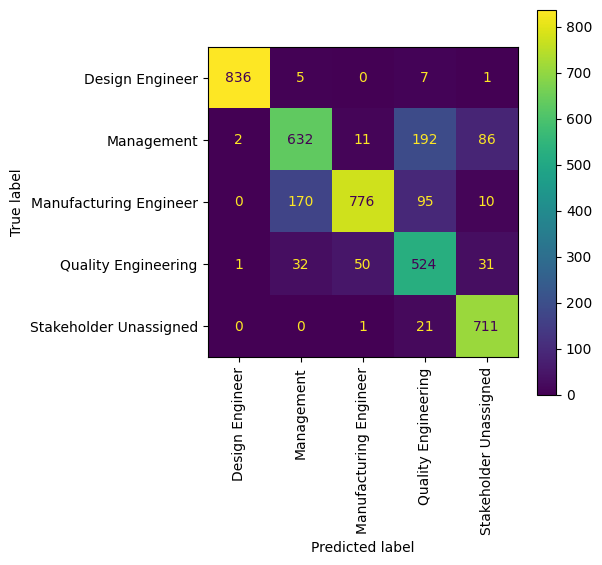

               Accuracy  Precision   Recall       F1  Training time (s)
Model                                                                  
XGBClassifier   82.9518    82.9541  83.9812  82.8723            8.29054

Fold-5		Average F1 train score: 0.844 - Average F1 test score: 0.812
Fold-10		Average F1 train score: 0.843 - Average F1 test score: 0.814
Fold-15		Average F1 train score: 0.842 - Average F1 test score: 0.815
Fold-20		Average F1 train score: 0.842 - Average F1 test score: 0.814
____________________________________________________________________________________________________
			 StochasticGradientDescent
Training time: 4.255 seconds

Accuracy: 80.1144%
Precision: 80.1117%
Recall: 83.3828%
F1-Score: 80.3557%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.96      0.98       872
            Management       0.91      0.58      0.70      1323
Manufacturing Engineer       0.68      0.91      0.

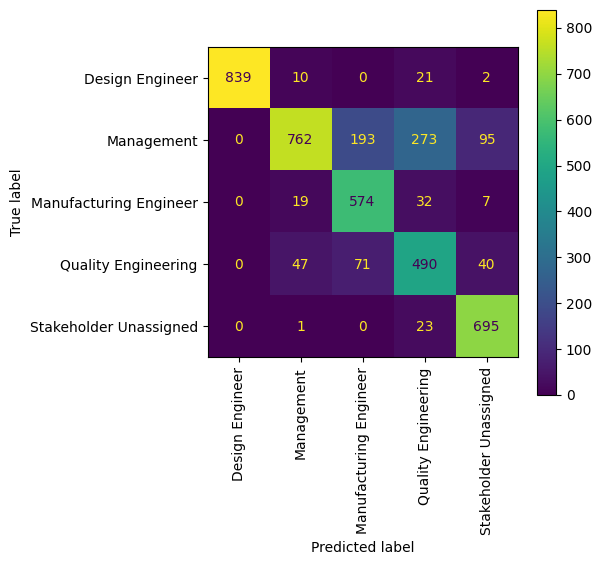

               Accuracy  Precision   Recall       F1  Training time (s)
Model                                                                  
SGDClassifier   80.1144    80.1117  83.3828  80.3557           4.254727

Fold-5		Average F1 train score: 0.808 - Average F1 test score: 0.787
Fold-10		Average F1 train score: 0.813 - Average F1 test score: 0.805
Fold-15		Average F1 train score: 0.804 - Average F1 test score: 0.785
Fold-20		Average F1 train score: 0.804 - Average F1 test score: 0.788
____________________________________________________________________________________________________


In [ ]:
# Define the cross validation list
cross_validation = [5, 10, 15, 20]

MODELS_RESULT = []
CV_MODELS_RESULT = []

for i in tqdm(model_tuple, desc="model running"):
    print("=" * 100)
    print(f"\t\t\t {i[0]}")
    print("=" * 100)
    RESULT = train_model(i[1])
    df_results = get_model_results(RESULT)
    MODELS_RESULT.append(df_results)
    print(df_results)
    print()
    RES = check_cross_validation_score(cross_validation, i[1])
    df_results_cv_lr = get_cv_results(RES)
    CV_MODELS_RESULT.append(df_results_cv_lr)
    print("_" * 100)

In [ ]:
df_all_models = pd.concat(
    [
        MODELS_RESULT[0],
        MODELS_RESULT[1],
        MODELS_RESULT[2],
        MODELS_RESULT[3],
        MODELS_RESULT[4],
        MODELS_RESULT[5],
        MODELS_RESULT[6],
    ]
)
df_all_models

Accuracy  Precision   Recall       F1  \
Model                                                           
LogisticRegression       81.4735    81.4779  83.5969  80.7383   
GaussianNB               63.1140    63.1220  64.9656  58.9244   
RandomForestClassifier   81.7835    81.7874  84.1478  81.3565   
SVC                      83.0234    83.0259  84.1032  82.8634   
AdaBoostClassifier       79.2799    79.2823  79.0978  78.6981   
XGBClassifier            82.9518    82.9541  83.9812  82.8723   
SGDClassifier            80.1144    80.1117  83.3828  80.3557   

                        Training time (s)  
Model                                      
LogisticRegression               0.758217  
GaussianNB                       0.090566  
RandomForestClassifier           2.343538  
SVC                              7.549622  
AdaBoostClassifier              22.129671  
XGBClassifier                    8.290540  
SGDClassifier                    4.254727

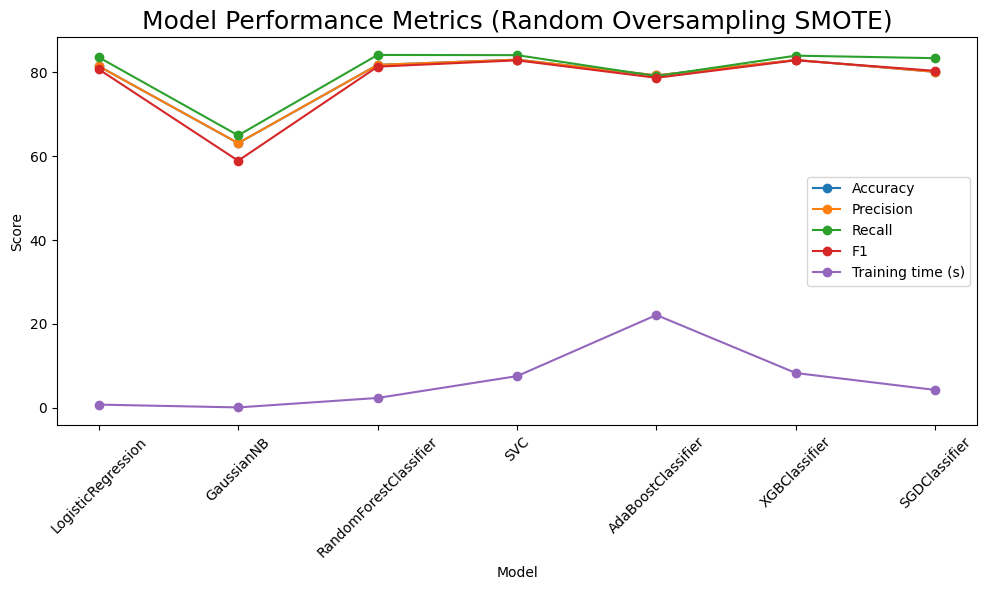

In [ ]:
# Assuming df_all_models contains columns: 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Training time (s)'
plt.figure(figsize=(10, 6))
metrics = ["Accuracy", "Precision", "Recall", "F1", "Training time (s)"]
models = df_all_models.index

for metric in metrics:
    plt.plot(models, df_all_models[metric], marker="o", label=metric)

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance Metrics (Random Oversampling SMOTE)", fontsize=18)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_all_models_cv = pd.concat(
    [
        CV_MODELS_RESULT[0],
        CV_MODELS_RESULT[1],
        CV_MODELS_RESULT[2],
        CV_MODELS_RESULT[3],
        CV_MODELS_RESULT[4],
        CV_MODELS_RESULT[5],
        CV_MODELS_RESULT[6],
    ]
).set_index("cross-validation")
df_all_models_cv

F1_train_score  F1_test_score
cross-validation                                             
LogisticRegression-Fold-5             0.810994       0.795817
LogisticRegression-Fold-10            0.814806       0.804087
LogisticRegression-Fold-15            0.814690       0.804089
LogisticRegression-Fold-20            0.814284       0.802446
GaussianNB-Fold-5                     0.611722       0.604912
GaussianNB-Fold-10                    0.611339       0.604246
GaussianNB-Fold-15                    0.611264       0.601409
GaussianNB-Fold-20                    0.610650       0.599668
RandomForestClassifier-Fold-5         0.838272       0.806945
RandomForestClassifier-Fold-10        0.836675       0.807909
RandomForestClassifier-Fold-15        0.835571       0.808421
RandomForestClassifier-Fold-20        0.835279       0.808633
SVC-Fold-5                            0.832432       0.809865
SVC-Fold-10                           0.833104       0.814529
SVC-Fold-15                           0.832865       0.814037
SVC-Fold-20                           0.832724       0.814390
AdaBoostClassifier-Fold-5             0.805691       0.771968
AdaBoostClassifier-Fold-10            0.811304       0.774382
AdaBoostClassifier-Fold-15            0.814688       0.781812
AdaBoostClassifier-Fold-20            0.808141       0.779205
XGBClassifier-Fold-5                  0.843657       0.812002
XGBClassifier-Fold-10                 0.842628       0.814313
XGBClassifier-Fold-15                 0.842427       0.814849
XGBClassifier-Fold-20                 0.842435       0.813826
SGDClassifier-Fold-5                  0.807827       0.787195
SGDClassifier-Fold-10                 0.812584       0.804512
SGDClassifier-Fold-15                 0.804492       0.784642
SGDClassifier-Fold-20                 0.803616       0.788204

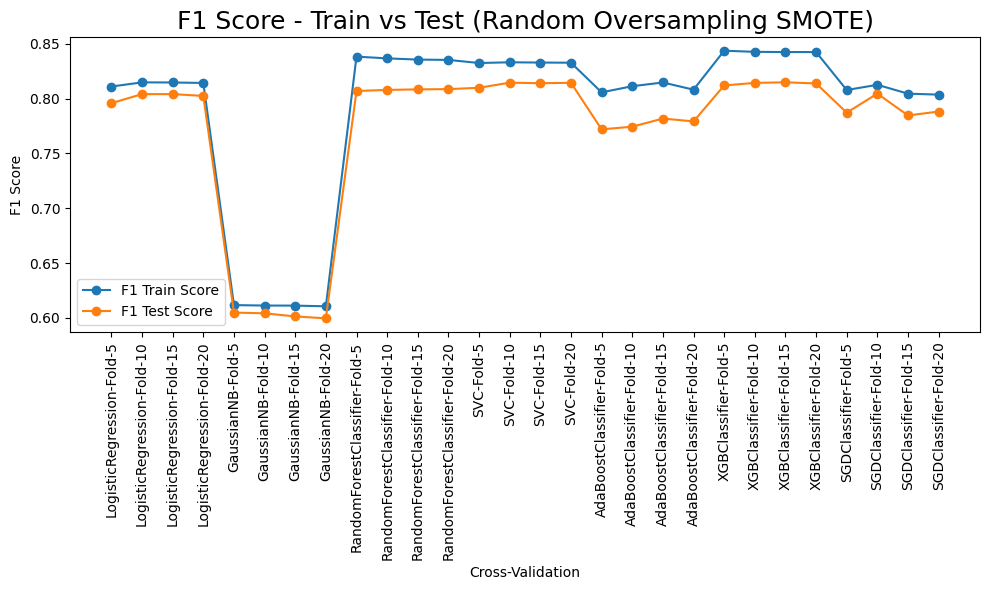

In [ ]:
# Assuming df_all_models_cv contains columns: 'cross-validation', 'F1_train_score', 'F1_test_score'
plt.figure(figsize=(10, 6))
models_cv = df_all_models_cv.index

plt.plot(
    models_cv, df_all_models_cv["F1_train_score"], marker="o", label="F1 Train Score"
)
plt.plot(
    models_cv, df_all_models_cv["F1_test_score"], marker="o", label="F1 Test Score"
)

plt.xlabel("Cross-Validation")
plt.ylabel("F1 Score")
plt.title("F1 Score - Train vs Test (Random Oversampling SMOTE)", fontsize=18)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## **Random undersampling**

In [ ]:
undersample = RandomUnderSampler(random_state=42)
underX, underY = undersample.fit_resample(X_tfidff, y)

pd.DataFrame(underY)["PRIMARY_LABEL_ENC"].value_counts()

0    45
1    45
2    45
3    45
4    45
Name: PRIMARY_LABEL_ENC, dtype: int64

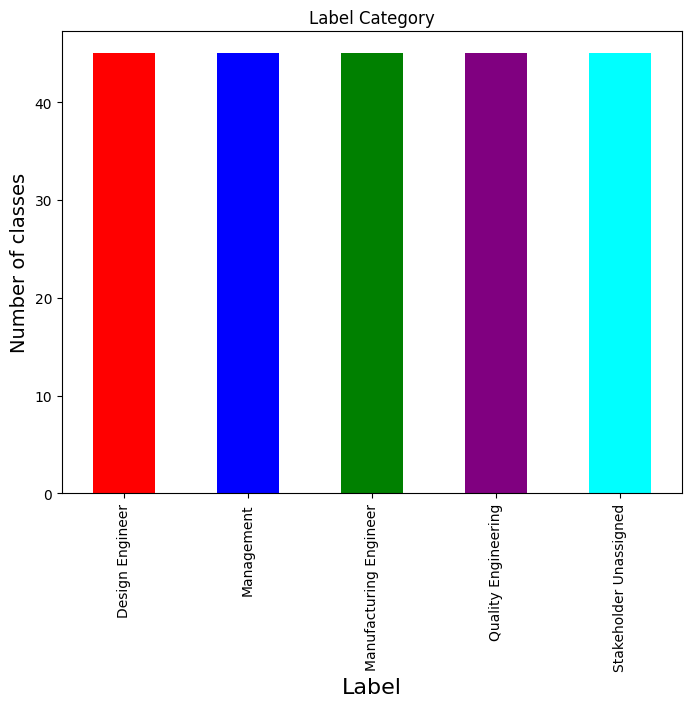

In [ ]:
# First under sampling to make all classes equal

ax = (
    pd.DataFrame(underY)["PRIMARY_LABEL_ENC"]
    .value_counts()
    .plot(
        kind="bar",
        color=["red", "blue", "green", "purple", "cyan"],
        title="Label Category",
        figsize=(8, 6),
    )
)

plt.xticks(range(5), label_enc.classes_.tolist())
ax.set_xlabel("Label", fontsize=16)
ax.set_ylabel("Number of classes", fontsize=14)
plt.show()

In [ ]:
# split data into 75% training and 25% testing set
X_train_tfidf, X_test_tfidf, y_train, y_test = splitting_dataset(
    underX, underY, test_size=0.25
)

training shape : (168, 470)
testing shape : (57, 470)


model running:   0%|          | 0/7 [00:00<?, ?it/s]

			 LogisticRegression
Training time: 0.007 seconds

Accuracy: 70.1754%
Precision: 70.1515%
Recall: 72.1266%
F1-Score: 70.1771%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      1.00      1.00        11
            Management       0.45      0.71      0.56         7
Manufacturing Engineer       0.64      0.44      0.52        16
   Quality Engineering       0.42      0.45      0.43        11
Stakeholder Unassigned       1.00      1.00      1.00        12

              accuracy                           0.70        57
             macro avg       0.70      0.72      0.70        57
          weighted avg       0.72      0.70      0.70        57


Confusion Matrix:


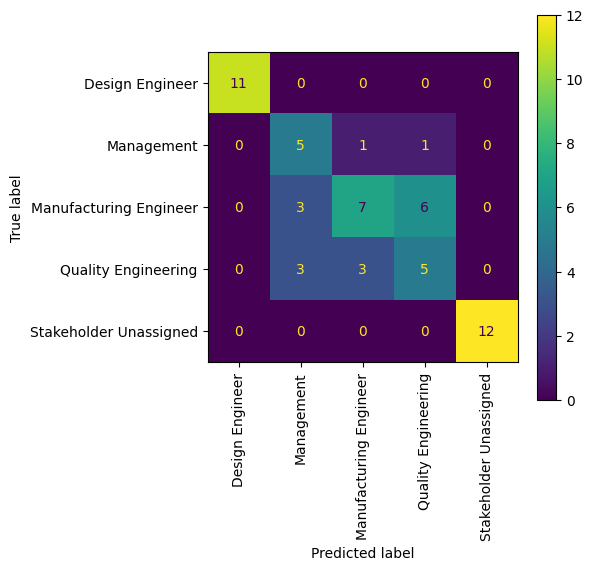

                    Accuracy  Precision   Recall       F1  Training time (s)
Model                                                                       
LogisticRegression   70.1754    70.1515  72.1266  70.1771           0.007345

Fold-5		Average F1 train score: 0.904 - Average F1 test score: 0.596
Fold-10		Average F1 train score: 0.894 - Average F1 test score: 0.595
Skipping cross-validation for Fold-15 due to insufficient samples in the smallest class.
Skipping cross-validation for Fold-20 due to insufficient samples in the smallest class.
____________________________________________________________________________________________________
			 GaussianNB
Training time: 0.004 seconds

Accuracy: 61.4035%
Precision: 61.9697%
Recall: 55.9041%
F1-Score: 56.8072%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       0.91      0.77      0.83        13
            Management       0.91      0.45      0.61        22
Manufacturing

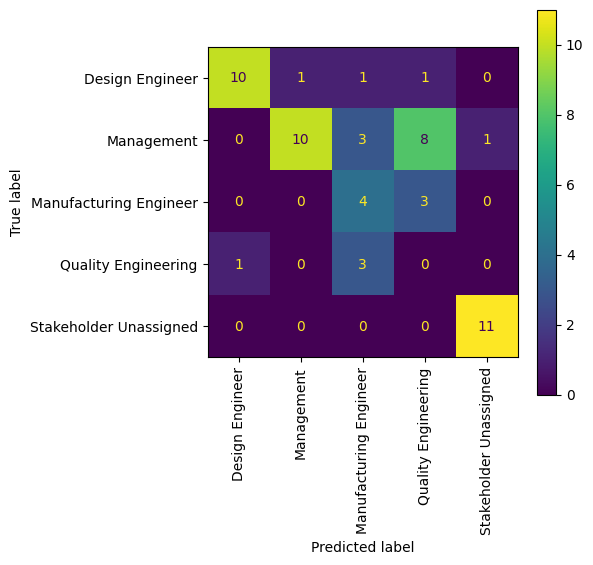

            Accuracy  Precision   Recall       F1  Training time (s)
Model                                                               
GaussianNB   61.4035    61.9697  55.9041  56.8072           0.004069

Fold-5		Average F1 train score: 0.815 - Average F1 test score: 0.500
Fold-10		Average F1 train score: 0.812 - Average F1 test score: 0.534
Skipping cross-validation for Fold-15 due to insufficient samples in the smallest class.
Skipping cross-validation for Fold-20 due to insufficient samples in the smallest class.
____________________________________________________________________________________________________
			 RandomForest
Training time: 0.157 seconds

Accuracy: 66.6667%
Precision: 66.5152%
Recall: 67.2191%
F1-Score: 65.6686%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.92      0.96        12
            Management       0.36      0.67      0.47         6
Manufacturing Engineer       0.55  

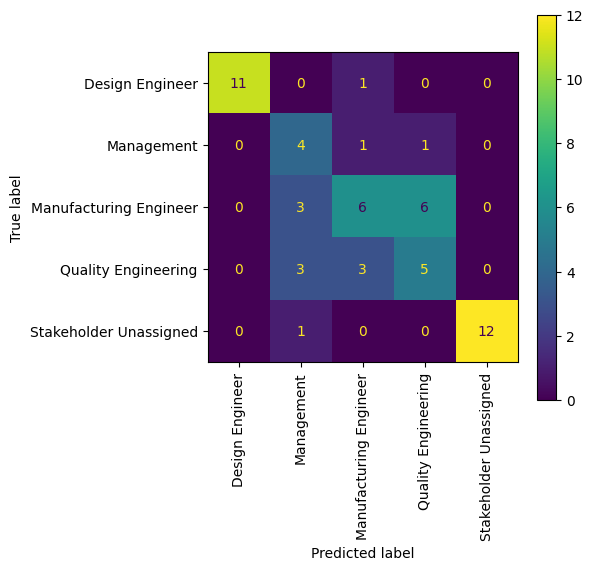

                        Accuracy  Precision   Recall       F1  \
Model                                                           
RandomForestClassifier   66.6667    66.5152  67.2191  65.6686   

                        Training time (s)  
Model                                      
RandomForestClassifier            0.15695  

Fold-5		Average F1 train score: 0.907 - Average F1 test score: 0.557
Fold-10		Average F1 train score: 0.896 - Average F1 test score: 0.590
Skipping cross-validation for Fold-15 due to insufficient samples in the smallest class.
Skipping cross-validation for Fold-20 due to insufficient samples in the smallest class.
____________________________________________________________________________________________________
			 SVM
Training time: 0.010 seconds

Accuracy: 70.1754%
Precision: 70.0%
Recall: 70.5611%
F1-Score: 69.4763%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.92      0.96 

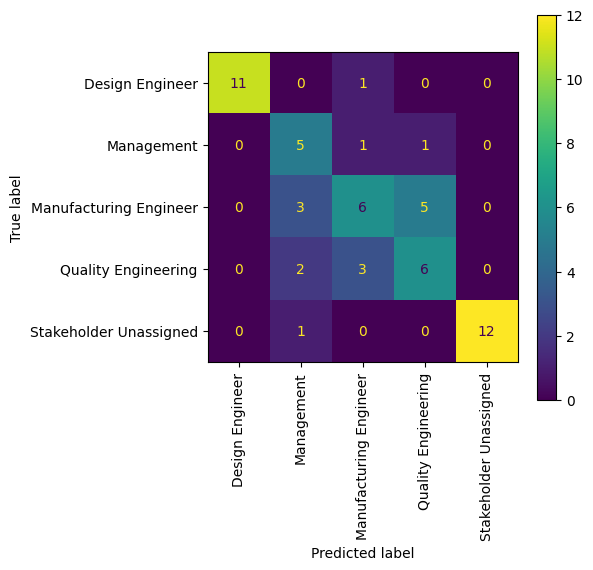

       Accuracy  Precision   Recall       F1  Training time (s)
Model                                                          
SVC     70.1754       70.0  70.5611  69.4763           0.009629

Fold-5		Average F1 train score: 0.909 - Average F1 test score: 0.568
Fold-10		Average F1 train score: 0.898 - Average F1 test score: 0.530
Skipping cross-validation for Fold-15 due to insufficient samples in the smallest class.
Skipping cross-validation for Fold-20 due to insufficient samples in the smallest class.
____________________________________________________________________________________________________
			 AdaBoost
Training time: 0.391 seconds

Accuracy: 64.9123%
Precision: 64.697%
Recall: 65.0866%
F1-Score: 63.4273%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       0.91      0.91      0.91        11
            Management       0.36      0.67      0.47         6
Manufacturing Engineer       0.55      0.43      0.48  

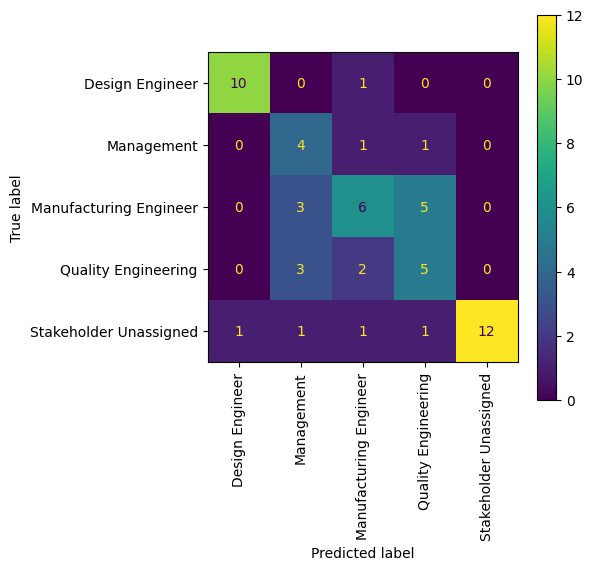

                    Accuracy  Precision   Recall       F1  Training time (s)
Model                                                                       
AdaBoostClassifier   64.9123     64.697  65.0866  63.4273           0.391337

Fold-5		Average F1 train score: 0.907 - Average F1 test score: 0.623
Fold-10		Average F1 train score: 0.897 - Average F1 test score: 0.555
Skipping cross-validation for Fold-15 due to insufficient samples in the smallest class.
Skipping cross-validation for Fold-20 due to insufficient samples in the smallest class.
____________________________________________________________________________________________________
			 XGBoost
Training time: 0.586 seconds

Accuracy: 68.4211%
Precision: 68.1818%
Recall: 68.29%
F1-Score: 67.0385%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.92      0.96        12
            Management       0.36      0.67      0.47         6
Manufacturing Engi

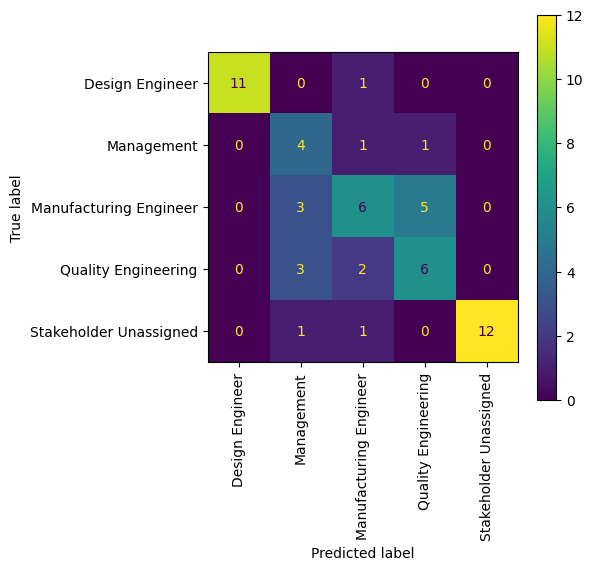

               Accuracy  Precision  Recall       F1  Training time (s)
Model                                                                 
XGBClassifier   68.4211    68.1818   68.29  67.0385           0.586344

Fold-5		Average F1 train score: 0.909 - Average F1 test score: 0.600
Fold-10		Average F1 train score: 0.898 - Average F1 test score: 0.585
Skipping cross-validation for Fold-15 due to insufficient samples in the smallest class.
Skipping cross-validation for Fold-20 due to insufficient samples in the smallest class.
____________________________________________________________________________________________________
			 StochasticGradientDescent
Training time: 0.048 seconds

Accuracy: 70.1754%
Precision: 70.1515%
Recall: 72.6667%
F1-Score: 69.9977%

Classification Report:
                        precision    recall  f1-score   support

       Design Engineer       1.00      0.92      0.96        12
            Management       0.45      0.83      0.59         6
Manufacturing En

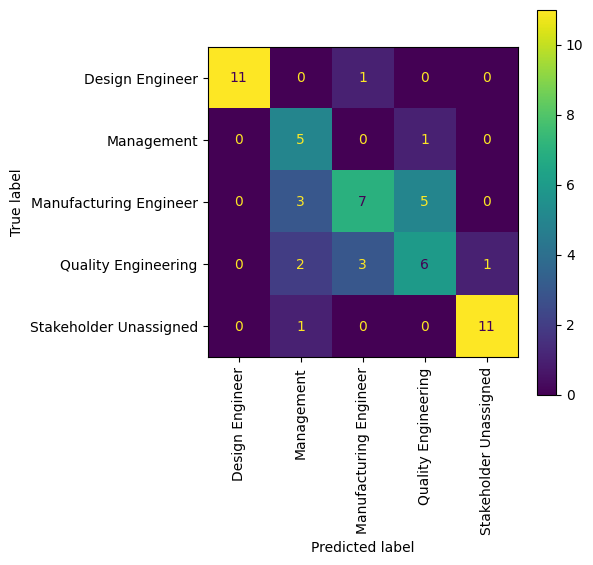

               Accuracy  Precision   Recall       F1  Training time (s)
Model                                                                  
SGDClassifier   70.1754    70.1515  72.6667  69.9977           0.047584

Fold-5		Average F1 train score: 0.856 - Average F1 test score: 0.602
Fold-10		Average F1 train score: 0.872 - Average F1 test score: 0.595
Skipping cross-validation for Fold-15 due to insufficient samples in the smallest class.
Skipping cross-validation for Fold-20 due to insufficient samples in the smallest class.
____________________________________________________________________________________________________


In [ ]:
# Define the cross validation list
cross_validation = [5, 10, 15, 20]

MODELS_RESULT = []
CV_MODELS_RESULT = []

for i in tqdm(model_tuple, desc="model running"):
    print("=" * 100)
    print(f"\t\t\t {i[0]}")
    print("=" * 100)
    RESULT = train_model(i[1])
    df_results = get_model_results(RESULT)
    MODELS_RESULT.append(df_results)
    print(df_results)
    print()
    RES = check_cross_validation_score(cross_validation, i[1])
    df_results_cv_lr = get_cv_results(RES)
    CV_MODELS_RESULT.append(df_results_cv_lr)
    print("_" * 100)

In [ ]:
df_all_models = pd.concat(
    [
        MODELS_RESULT[0],
        MODELS_RESULT[1],
        MODELS_RESULT[2],
        MODELS_RESULT[3],
        MODELS_RESULT[4],
        MODELS_RESULT[5],
        MODELS_RESULT[6],
    ]
)
df_all_models

Accuracy  Precision   Recall       F1  \
Model                                                           
LogisticRegression       70.1754    70.1515  72.1266  70.1771   
GaussianNB               61.4035    61.9697  55.9041  56.8072   
RandomForestClassifier   66.6667    66.5152  67.2191  65.6686   
SVC                      70.1754    70.0000  70.5611  69.4763   
AdaBoostClassifier       64.9123    64.6970  65.0866  63.4273   
XGBClassifier            68.4211    68.1818  68.2900  67.0385   
SGDClassifier            70.1754    70.1515  72.6667  69.9977   

                        Training time (s)  
Model                                      
LogisticRegression               0.007345  
GaussianNB                       0.004069  
RandomForestClassifier           0.156950  
SVC                              0.009629  
AdaBoostClassifier               0.391337  
XGBClassifier                    0.586344  
SGDClassifier                    0.047584

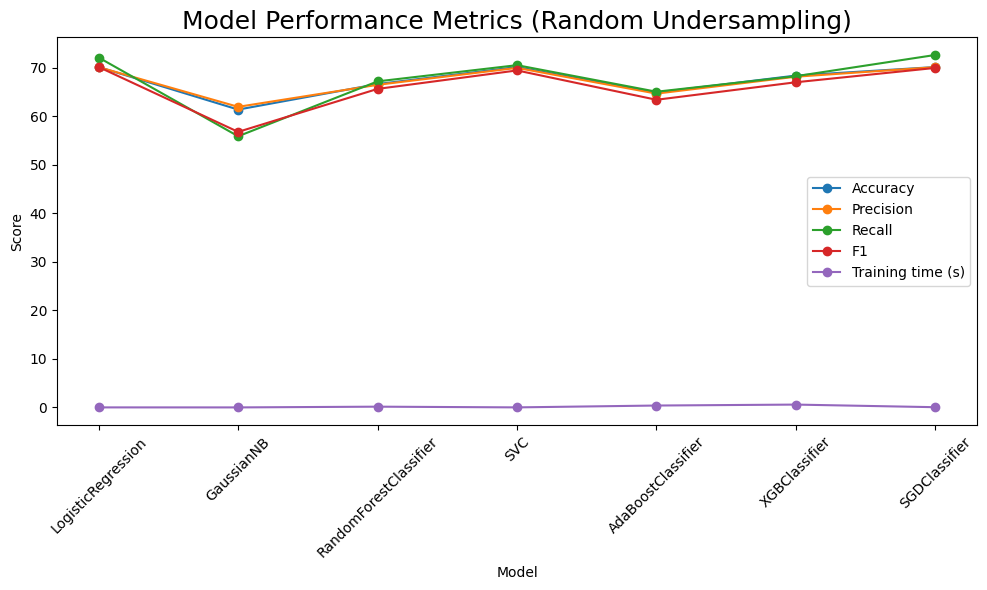

In [ ]:
# Assuming df_all_models contains columns: 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Training time (s)'
plt.figure(figsize=(10, 6))
metrics = ["Accuracy", "Precision", "Recall", "F1", "Training time (s)"]
models = df_all_models.index

for metric in metrics:
    plt.plot(models, df_all_models[metric], marker="o", label=metric)

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance Metrics (Random Undersampling)", fontsize=18)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_all_models_cv = pd.concat(
    [
        CV_MODELS_RESULT[0],
        CV_MODELS_RESULT[1],
        CV_MODELS_RESULT[2],
        CV_MODELS_RESULT[3],
        CV_MODELS_RESULT[4],
        CV_MODELS_RESULT[5],
        CV_MODELS_RESULT[6],
    ]
).set_index("cross-validation")
df_all_models_cv

F1_train_score  F1_test_score
cross-validation                                             
LogisticRegression-Fold-5             0.904321       0.595810
LogisticRegression-Fold-10            0.893925       0.594667
GaussianNB-Fold-5                     0.815360       0.500000
GaussianNB-Fold-10                    0.811726       0.534000
RandomForestClassifier-Fold-5         0.907160       0.557333
RandomForestClassifier-Fold-10        0.896243       0.590000
SVC-Fold-5                            0.909067       0.568190
SVC-Fold-10                           0.898259       0.530000
AdaBoostClassifier-Fold-5             0.906559       0.622667
AdaBoostClassifier-Fold-10            0.896548       0.554667
XGBClassifier-Fold-5                  0.909249       0.599968
XGBClassifier-Fold-10                 0.897848       0.584667
SGDClassifier-Fold-5                  0.856343       0.602476
SGDClassifier-Fold-10                 0.872019       0.594667

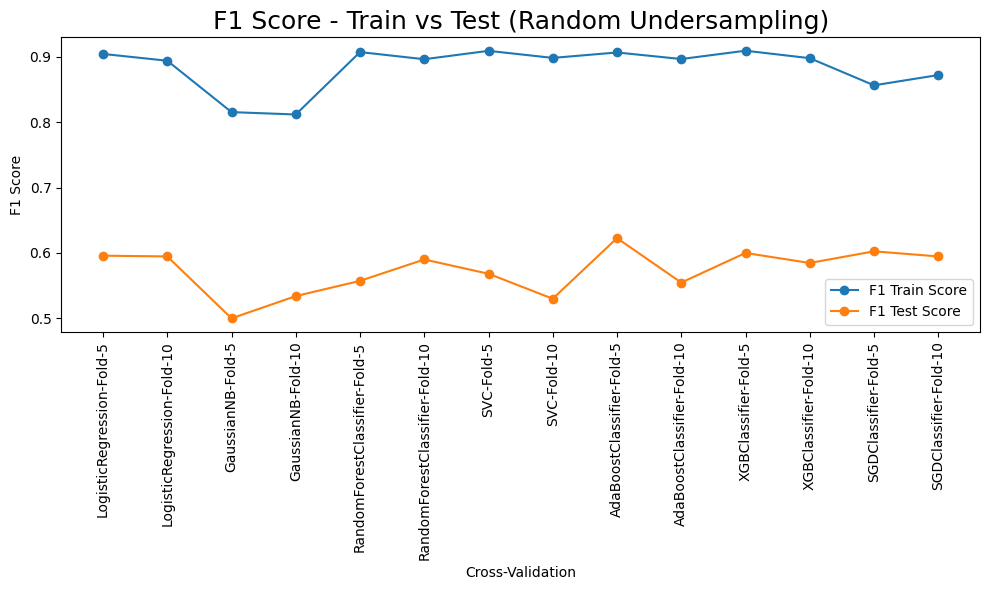

In [ ]:
# Assuming df_all_models_cv contains columns: 'cross-validation', 'F1_train_score', 'F1_test_score'
plt.figure(figsize=(10, 6))
models_cv = df_all_models_cv.index

plt.plot(
    models_cv, df_all_models_cv["F1_train_score"], marker="o", label="F1 Train Score"
)
plt.plot(
    models_cv, df_all_models_cv["F1_test_score"], marker="o", label="F1 Test Score"
)

plt.xlabel("Cross-Validation")
plt.ylabel("F1 Score")
plt.title("F1 Score - Train vs Test (Random Undersampling)", fontsize=18)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()